In [105]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp
import datetime

import matplotlib.pylab as plt
import os
import random
import math

import seaborn as sns

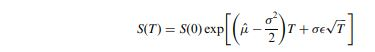

Using the above stochastic equation for an equity, a Monte Carlo simulation function is built considering the correlation of the two hypothetical stocks in the scope for  given level of initial stock prices, volatilities, correlation matrix expected returns, Time, intervals, period and number of simulations. Cholesky decomposition is used for getting the correct covariance matrix between the two stocks in scope.

After getting the future paths for the period set in the simulation of the correlated stocks in scope, a portfolio can be constructed with any given weights and then portfolio returns are calculated. Post this step, the portfolio returns are sorted in ascending order and worst 1-day portfolio retuns at 5% & 1% cutoff are then multiplied with square root of 10 for 10-Day VaR calculation at 95% & 99% confidence interval respectively.


In [97]:
def return_calc(data_set,l):    # Function to calculate returns and convert it to dataframe
    
    return_A=[]
    return_B=[]

    for r in range(0,l-1):
        ret_A=np.log(data_set[0][r+1]/data_set[0][0])
        ret_B=np.log(data_set[1][r+1]/data_set[1][0])
        return_A.append(ret_A)
        return_B.append(ret_B)

    return pd.DataFrame (list(zip(return_A,return_B)),columns=['A','B'])

In [98]:
def Rho_matrix(RhoAB):            #Correlelation matrix
    corr=np.array([[1.0,RhoAB],
                  [RhoAB,1.0]])
    return corr


def MC(ER_A,ER_B,S0_A,S0_B,sigma_A,sigma_B,RhoAB,intervals,period,sim): # Monte Carlo Simulation of daily paths of stock A & stock B using GBM equation
    
    
    std=np.diag([sigma_A, sigma_B])  #volatility matrix of stock A and stock B
    corr_matrix=Rho_matrix(RhoAB)    #correlation matrix of stock A & stock B
    cov_matrix=np.dot(std,np.dot(std,corr_matrix))      # covariance matrix 
    L = np.linalg.cholesky(np.array(cov_matrix)) # Cholesky decomposition of cov matrix to get bivariate normal distribution
    T=1.0 
    
    path_A=[] #storing the final values at end of specified period for each simulation for stock A
    path_B=[] #storing the final values at end of specified period for each simulation for stock B
    
    for j in range(sim):
        scenario_A = []  # storing simulated prices of stock A for each time interval till end of specified period
        scenario_B = []  # storing simulated prices of stock B for each time interval till end of specified period
        ST0_A=S0_A
        ST0_B=S0_B
        for i in range(period):
            sp.random.seed(12345+i+j)
            V = L.dot(np.random.normal(0, 1, 2))
        
            ST_A=ST0_A*np.exp((ER_A-(sigma_A**2)/2)*(T/intervals)+sigma_A*V[0]*np.sqrt(T/intervals))
            ST_B=ST0_B*np.exp((ER_B-(sigma_B**2)/2)*(T/intervals)+sigma_B*V[1]*np.sqrt(T/intervals))
            scenario_A.append(ST_A)
            scenario_B.append(ST_B)
            ST0_A=ST_A
            ST0_B=ST_B
        path_A.append(scenario_A[period-1]) 
        path_B.append(scenario_B[period-1])
    return pd.DataFrame (list(zip(path_A,path_B)),columns=['A','B'])


In [99]:
#correlation=Rho_matrix(0.8)
MC(0.14,0.18,300,200,0.25,0.3,+0.6,252,10,100) # 100 simulation runs for two stocks A & B till period of 10th day

,A,B
0,301.328087,203.770900
1,298.882065,201.769801
2,299.798065,201.677881
3,300.077418,200.688659
4,299.435981,201.055980
...,...,...
95,305.420781,202.592560
96,304.088808,202.468600
97,305.247116,205.423887
98,304.242614,204.129132


In [100]:
'''10k Monte Carlo Simulation of prices of Stock A & Stock B for next day by setting period as 1 and time interval as 252 (as typically theer are 252 trading days in a year) while T=1 (year)'''
port=MC(-0.3,0.18,300,200,0.25,0.3,+0.6,252,1,10000)
w1,w2=0.5,0.5  #portfolio with equal weights 
port['returns']=(port['A']/300-1)*w1+(port['B']/200-1)*w2
port

,A,B,returns
0,299.364541,200.317147,-0.000266
1,299.499791,200.632223,0.000747
2,300.011597,201.850733,0.004646
3,301.154646,199.879784,0.001624
4,298.603056,199.210057,-0.004303
...,...,...,...
9995,301.074337,202.160869,0.007193
9996,300.015385,199.215361,-0.001936
9997,297.976577,200.635527,-0.001784
9998,300.138825,201.492787,0.003963


In [101]:
port.sort_values(['returns'],inplace=True,ascending=True)
port

,A,B,returns
8338,295.164652,195.456249,-0.019418
9457,295.500459,196.428090,-0.016429
4241,296.657947,195.780153,-0.016120
8355,296.179421,196.728325,-0.014547
8611,295.926029,197.288159,-0.013570
...,...,...,...
9456,302.727322,204.086355,0.014761
4152,303.463937,203.779283,0.015221
9108,303.444047,203.817396,0.015284
6131,303.170118,204.019486,0.015332


In [102]:
VaR95=port['returns'].quantile(0.05)*np.sqrt(10)
VaR99=port['returns'].quantile(0.01)*np.sqrt(10)
print ('VaR95: {:.2%}' .format(VaR95)) #Value at Risk at 95% confidence interval over 10 days in returns term
print ('VaR99: {:.2%}' .format(VaR99)) #Value at Risk at 99% confidence interval over 10 days in returns term

VaR95: -2.45%
VaR99: -3.53%


In [ ]:
'''Below are two graphs showing distribution of portfolio returns along with probability and KDE'''

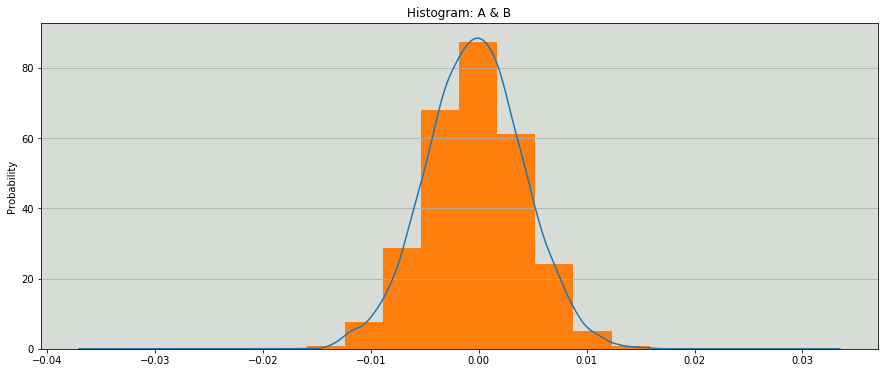

In [104]:
fig, ax = plt.subplots()
port['returns'].plot.kde(ax=ax, legend=False, title='Histogram: A & B')
port['returns'].plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

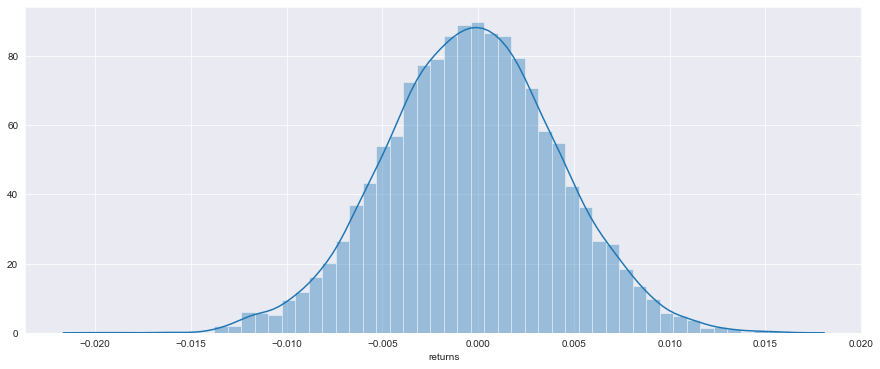

In [107]:
sns.set_style('darkgrid')
sns.distplot(port['returns'])
plt.show()